In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler
#import torchvision
#import lightning


In [3]:
# data_dir = os.path.join(os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py/data_batch_1")
data_dir = os.path.join(
    os.path.dirname(os.getcwd()),
    "Data/CIFAR10/cifar-10-batches-py",
    "train_data.pkl",
)
data_dir_val = os.path.join(
    os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py/test_batch"
)

num_classes = 10
# batch_size = 2
num_in_channels = 3
dim_z = 64
kern_size = 4
lr = 2e-4
num_epochs = 3

num_disc_feat = 128
disc_stride = 1
disc_padding_size = 0

num_gen_feat = 128
gen_stride = 3
gen_padding_size = 1

mean = 0.0
std = 0.02  # from the DCGAN paper

if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"


In [4]:
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [102]:
def process_data(folder_dir):
    file_paths = os.listdir(folder_dir)
    combined_img_data = []
    combined_label_data = []
    for file in file_paths:
        if "data_batch" in file:
            combined_img_data.append(
                unpickle(os.path.join(folder_dir, file))[b"data"]
            )
            combined_label_data.append(
                unpickle(os.path.join(folder_dir, file))[b"labels"]
            )
    combined_img_data = np.concatenate(combined_img_data)
    combined_label_data = np.concatenate(combined_label_data)
    # with open(os.path.join(folder_dir, "train_img_data.pkl"), 'wb') as f:
    #     pickle.dump(combined_img_data, f)
    # with open(os.path.join(folder_dir, "train_label_data.pkl"), 'wb') as f:
    #     pickle.dump(combined_label_data, f)

    train_data = {}
    train_data[b"data"] = combined_img_data
    train_data[b"labels"] = combined_label_data
    with open(os.path.join(folder_dir, "train_data.pkl"), "wb") as f:
        pickle.dump(train_data, f)

In [ ]:
process_data(
    os.path.join(
        os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py"
    )
)

In [5]:
(unpickle(data_dir).keys())


dict_keys([b'data', b'labels'])

In [5]:
def normalize_image(image):
    image = image / 255.0
    image = (image - 0.5) * 2.0
    return image

In [79]:
class TrainDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        img_data = unpickle(data_dir)[b'data'][:100]
        label_data = unpickle(data_dir)[b'labels'][:100]
        self.train_data = {b"data": img_data, b"labels": label_data}

    def __getitem__(self, idx):
        de_norm_img = self.train_data[b"data"][idx].reshape(3, 32, 32).transpose(1, 2, 0)
        img = torch.tensor(
            normalize_image(de_norm_img),
            dtype=torch.float32,
        )
        # img = torch.nn.functional.normalize(img)
        label = torch.tensor(
            self.train_data[b"labels"][idx], dtype=torch.float32
        )
        # return img, label
        return {"img": img, "label": label}

    def __len__(self):
        return len(self.train_data[b"labels"])

In [80]:
class ValDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.val_data = unpickle(data_dir)

    def __getitem__(self, idx):
        de_norm_img = self.val_data[b"data"][idx].reshape(3, 32, 32).transpose(1, 2, 0)
        img = torch.tensor(
            normalize_image(de_norm_img), dtype=torch.float32
        )
        # img = torch.nn.functional.normalize(img)
        label = torch.tensor(self.val_data[b"labels"][idx], dtype=torch.float32)
        # return img, label
        return {"img": img, "label": label}

    def __len__(self):
        return len(self.val_data[b"labels"])

In [81]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ngpu = ngpu
        self.net = nn.Sequential(
            # nn.BatchNorm2d(num_in_channels),
            nn.Conv2d(
                num_in_channels,
                num_disc_feat,
                2,
                1,
                padding=0,
                bias=False,
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat,
                num_disc_feat * 2,
                2,
                2,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 2),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 2,
                num_disc_feat * 4,
                2,
                2,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 4),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 4,
                num_disc_feat * 8,
                2,
                2,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 8),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 8,
                1,
                2,
                2,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        for layer in self.net.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean, std)

    def forward(self, x):
        
        z = self.net(x)
        return z

In [82]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ngpu = ngpu
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                dim_z, num_gen_feat * 4, kern_size, 1, 0, bias=False
            ),
            # ConvTranspose2d are the fractionally strided convolutions used for upscaling mentioned in the paper
            nn.BatchNorm2d(num_gen_feat * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat * 4, num_gen_feat * 2, kern_size, 2, 1, bias=False
            ),
            nn.BatchNorm2d(num_gen_feat * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat * 2, num_gen_feat, kern_size, 2, 1, bias=False
            ),
            nn.BatchNorm2d(num_gen_feat),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat, num_in_channels, kern_size, 2, 1, bias=False
            ),
            nn.Tanh(),
        )

        for layer in self.net.modules():
            if isinstance(layer, nn.ConvTranspose2d):
                nn.init.normal_(layer.weight, mean, std)

    def forward(self, x):
        z = self.net(x)
        return z

In [50]:
train_dataset = TrainDataset(data_dir)
train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0, shuffle=True)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=train_sampler,
)

val_dataset = ValDataset(data_dir_val)
val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0, shuffle=True)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=val_sampler,
)

In [83]:
def denormalize_images(images):
    # Reverse normalization
    denormalized_images = (images + 1) / 2.0
    denormalized_images = (denormalized_images * 255).astype(np.uint8)
    return denormalized_images


In [84]:
 def one_hot_encoder(y):
    y_out = []
    for i in range(y.shape[0]):
        # num = np.array([-torch.inf for _ in range(num_classifications)])
        num = np.zeros(num_classes)
        # num = torch.zeros(num_classes, dtype=torch.float32)
        num[int(y[i].item())] = 1.0
        y_out.append(num)
    return torch.tensor(np.array(y_out), dtype=torch.float32, device=device)

In [90]:
def train(num_epochs, data_dir, data_dir_val, device, train=True, **kwargs):

    loss_fn = torch.nn.BCEWithLogitsLoss()

    batch_size = kwargs.get("batch_size", 100)
    gen_lr = kwargs.get("gen_lr", 2e-4)
    disc_lr = kwargs.get("disc_lr", 2e-4)
    k = kwargs.get("k", 1)
    
    train_dataset = TrainDataset(data_dir)
    train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0, shuffle=True)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=100,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        sampler=train_sampler,
    )
    if train == False:
        val_dataset = ValDataset(data_dir_val)
        val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0, shuffle=True)
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            sampler=val_sampler,
        )
    
    optimG = torch.optim.AdamW(gen.parameters(), lr=gen_lr, betas=(0.5, 0.999), weight_decay=0.2)
    optimD = torch.optim.AdamW(disc.parameters(), lr=disc_lr, betas=(0.5, 0.999), weight_decay=0.1)
    # optimD = torch.optim.SGD(disc.parameters(), lr=2e-4)

    # noise = torch.randn(28, dim_z, 1, 1, device=device)

    # real_label = 1
    # fake_label = 0
    loss_d, loss_g, imgs = [], [], []
    
    if train:
        for i in range(num_epochs):
            print(f"Epoch no. :  {i+1}")
            nan_flag = False
            if nan_flag==False:
                
                for _ in range(k):
                    if nan_flag==False:
                        for j, mini_batch in enumerate(train_loader):

                            optimD.zero_grad()

                            # train disc first
                            x_real = mini_batch["img"].to(device)
                            x_real = x_real.reshape(batch_size, num_in_channels, 32, 32)
                            labels = torch.full(
                                (batch_size,), 1.0, dtype=torch.float32, device=device
                            )
                            labels_real = mini_batch["label"].to(device)
                            labels_real = one_hot_encoder(labels_real)
                            out_disc_r = disc(x_real).flatten()
                            # out_disc_r = disc(x_real).reshape(batch_size, num_classes)

                            # print(out_disc_r)
                            loss_disc_r = loss_fn(out_disc_r, labels)
                            # loss_disc_r = loss_fn(out_disc_r, labels_real)
                            loss_disc_r.backward()

                            x_fake = gen(torch.randn(batch_size, dim_z, 1, 1, device=device))
                            labels = torch.full(
                                (batch_size,), 0.0, dtype=torch.float32, device=device
                            )
                            labels_fake = torch.randint(0, num_classes, (batch_size,), device=device)
                            labels_fake = one_hot_encoder(labels_fake)
                            
                            out_disc_f = disc(x_fake).flatten()
                            # out_disc_f = disc(x_fake).reshape(batch_size, num_classes)
                            loss_disc_f = loss_fn(out_disc_f, labels)
                            # loss_disc_f = loss_fn(out_disc_f, labels_fake)
                            
                            if torch.isnan(loss_disc_f) or torch.isnan(loss_disc_r):
                                nan_flag = True
                                break

                            loss_disc_f.backward()

                            loss_disc = (
                                loss_disc_f.mean().item() + loss_disc_r.mean().item()
                            ) / 2.0

                            loss_d.append(loss_disc)

                            # if j % 1000 == 0:
                              #  print(f"Discriminator loss after {j} steps = {loss_d[j + _*train_dataset.__len__()//batch_size + i*train_dataset.__len__()//batch_size]}")

                            optimD.step()
                    
                for j, mini_batch in enumerate(train_loader):

                    # train gen
                    optimG.zero_grad()

                    x_gen = gen(torch.randn(batch_size, dim_z, 1, 1, device=device))
                    x_gen = torch.nn.functional.normalize(x_gen)
                    # out = disc(x_gen).flatten().sigmoid()
                    out = disc(x_gen).flatten()
                    labels = torch.full(
                        (batch_size,), 1.0, dtype=torch.float32, device=device
                    )
                    loss_gen = loss_fn(out, labels)
                    loss_gen.backward()

                    loss_g.append(loss_gen.item())

                    if loss_disc == np.NaN or loss_gen.item() == np.NaN:
                        nan_flag = True
                        break

                    optimG.step()

                    # if j % 1000 == 0:
                      #   print(f"Generator loss after {j} steps = {loss_g[j + i*train_dataset.__len__()//batch_size]}")

                with torch.no_grad():
                    gen_img = gen(torch.rand(2, dim_z, 1, 1, device=device))
                    gen_img = denormalize_images(gen_img[0].cpu().detach().numpy().transpose(1, 2, 0))
                    imgs.append(gen_img)
                    plt.imshow(gen_img)
                    plt.show()
                    plt.imshow(denormalize_images(mini_batch['img'][0].cpu().numpy()))
                    plt.show()
                
    return loss_d, loss_g, imgs

In [91]:
disc = Discriminator().to(device)
gen = Generator().to(device)
loss_disc, loss_gen, images = [], [], []


In [ ]:
g_lr = 2e-4
for g_lr in np.arange(9e-5, 4e-4, 2e-5):
    for d_lr in np.arange(4e-5, 2e-4, 2e-5):
        for k in np.arange(2,5, 1):
            disc = Discriminator().to(device)
            gen = Generator().to(device)
            l_disc, l_gen, img = train(num_epochs=10, data_dir=data_dir,data_dir_val=data_dir_val, device=device, batch_size=50, disc_lr=d_lr, gen_lr=g_lr, k=k)
            loss_disc.append(l_disc)
            loss_gen.append(l_gen)
            images.append(img)

In [ ]:
g_lr = 1e-4
d_lr = 4e-4
k = 2
num_epochs = 10000
l_disc, l_gen, img = train(num_epochs, data_dir=data_dir,data_dir_val=data_dir_val, device=device, batch_size=100, disc_lr=d_lr, gen_lr=g_lr, k=k)
loss_disc.append(l_disc)
loss_gen.append(l_gen)
images.append(img)

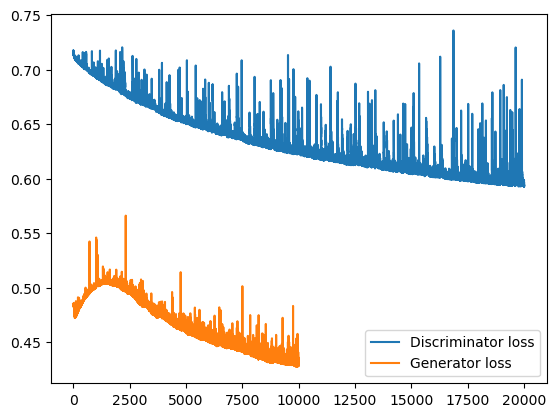

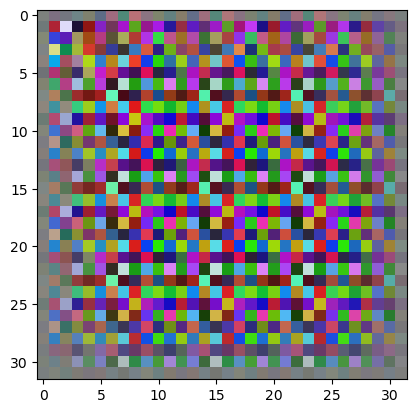

In [94]:
for i in range(len(loss_gen)):
    plt.plot(loss_disc[i])
    plt.plot(loss_gen[i])
    plt.legend(["Discriminator loss", "Generator loss"])
    plt.show()
    plt.imshow(images[i][-1])
    plt.show()
    # plt., loss_d[0]


In [95]:
with torch.no_grad():
    gen_img = gen(torch.rand(10, dim_z, 1, 1, device=device))

torch.Size([3, 32, 32])


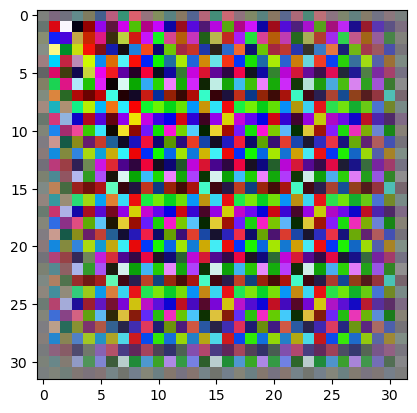

tensor([[[[0.0373]]],


        [[[0.0380]]],


        [[[0.0384]]],


        [[[0.0373]]],


        [[[0.0405]]],


        [[[0.0376]]],


        [[[1.0000]]],


        [[[0.0366]]],


        [[[0.0417]]],


        [[[0.0401]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [102]:
print(gen_img[0].shape)
plt.imshow(denormalize_images(gen_img[6].cpu().detach().transpose(0,1).transpose(1,2).numpy()))
plt.show()
print(disc(gen_img))
# print(disc(gen_img).flatten())